In [1]:
#@title Defining Imports
#numpy
import numpy as np
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
#for performance timing
import time
#utils
import random
import math
import types
from itertools import cycle
from sklearn.model_selection import ParameterGrid

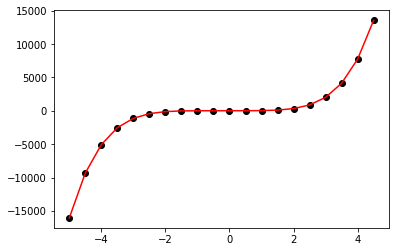

In [2]:
#@title Create and Render the Target Data
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')
plt.plot(Xi,yi, color="red")

In [3]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)
    self.fc2 = nn.Linear(middle,middle)
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

In [4]:
#@title Define HyperparametersGrid Class
class HyperparametersGrid(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)
    self.hparms = [d for d in self.__dict__]
    self.grid = {}
    self.gidx = 0
    if isinstance(self.__dict__[self.hparms[0]], types.GeneratorType):
      self.grid = self.create_grid()
      self.grid_size = len(self.grid)

  def __str__(self):
    out = ""
    for d in self.hparms:
      ds = self.__dict__[d]
      out += f"{d} = {ds} "
    return out

  def values(self):
    vals = []
    for d in self.hparms:
      vals.append(self.__dict__[d])
    return vals

  def create_grid(self):
    grid = {}
    for d in self.hparms:
      v,len = next(self.__dict__[d])
      row = []
      for i in range(len):
        v,_ = next(self.__dict__[d])
        row.append(v)
      grid[d] = row
    grid = ParameterGrid(grid)
    return grid

  def reset(self):
    self.gidx = 0

  def next(self):
    self.gidx += 1
    if self.gidx > self.grid_size-1:
      self.gidx = 0
    return HyperparametersGrid(**self.grid[self.gidx])

def grid(min, max, step):
  grid = cycle(np.arange(min, max, step))
  len = (max-min) / step
  for i in grid:
    yield i, int(len)

def grid_int(min, max, step):
  grid = cycle(range(min, max, step))
  len = (max-min) / step
  for i in grid:
    yield i, int(len)

In [5]:
#@title Populate the HyparameterGrid
hp = HyperparametersGrid(
  middle_layer = grid_int(8, 64, 6),
  learning_rate = grid(3.5e-02,3.5e-01, 3e-02),
  batch_size = grid_int(16, 20, 4),
  epochs = grid_int(200,225,25)
)

print(hp.grid_size)
print(hp.grid.param_grid)
print(hp.next())
print(hp.next())

90
[{'middle_layer': [14, 20, 26, 32, 38, 44, 50, 56, 62], 'learning_rate': [0.065, 0.095, 0.125, 0.155, 0.185, 0.215, 0.245, 0.275, 0.30500000000000005, 0.33499999999999996], 'batch_size': [16], 'epochs': [200]}]
middle_layer = 20 learning_rate = 0.065 epochs = 200 batch_size = 16 
middle_layer = 26 learning_rate = 0.065 epochs = 200 batch_size = 16 


In [6]:
#@title Setup CUDA for GPU use
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Not using CUDA


middle_layer = 32 learning_rate = 0.065 epochs = 200 batch_size = 16 
4977.89794921875


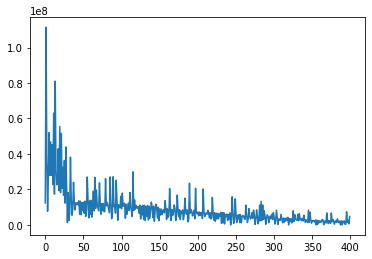

In [7]:
#@title Wrapper Function
loss_fn = nn.MSELoss()
if cuda:
  loss_fn.cuda()

def train_function(hp):
  hp = hp.next()

  X = np.reshape(
      np.arange(
          data_min,
          data_max,
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]

  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)

  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  if cuda:
    model.cuda()

  history=[]
  start = time.time()
  for i in range(hp.epochs):
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X).type(Tensor))
      y_batch = Variable(torch.Tensor(y).type(Tensor))
      # forward pass
      y_pred = model(x_batch)
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)
      ll = loss.data
      history.append(ll)
      # reset gradients
      optimizer.zero_grad()
      # backwards pass
      loss.backward()
      # step the optimizer - update the weights
      optimizer.step()
  end = time.time() - start
  return end, history, model, hp

best = float("inf")
span, history, model, hp_out = train_function(hp)
print(hp_out)
plt.plot(history)
print(min(history).item())

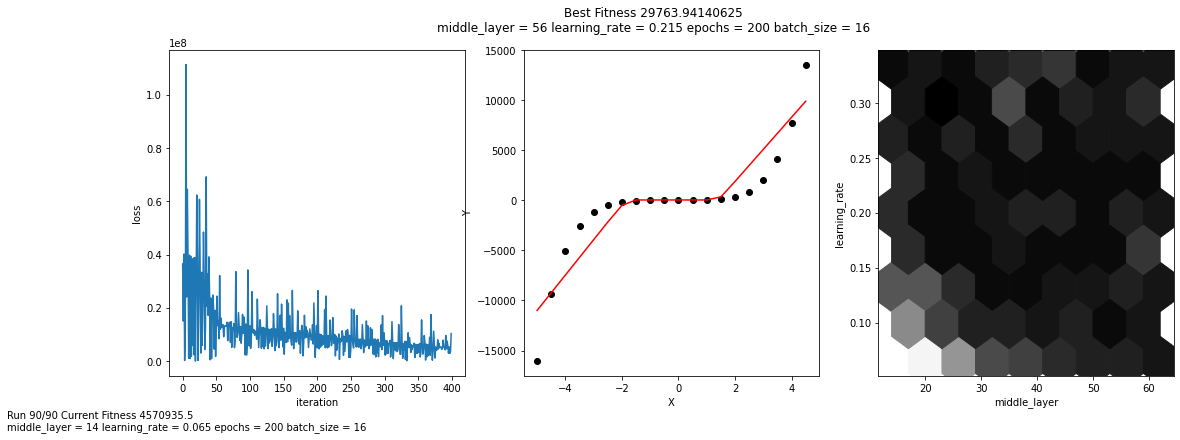

In [8]:
#@title Run the HPO
runs = hp.grid_size
grid_size = int(math.sqrt(runs))-1
hp.reset()

best = float("inf")
best_hp = None
run_history = []

for i in range(runs):
  span, history, model, hp_out = train_function(hp)
  y_ = model(torch.Tensor(Xi).type(Tensor))
  fitness = loss_fn(y_, torch.Tensor(yi).type(Tensor)).data.item()

  run_history.append([fitness,*hp_out.values()])
  if fitness < best:
    best = fitness
    best_hp = hp_out
  clear_output()
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
  fig.suptitle(f"Best Fitness {best} \n{best_hp}")
  fig.text(0,0,f"Run {i+1}/{runs} Current Fitness {fitness} \n{hp_out}")
  ax1.plot(history)
  ax1.set_xlabel("iteration")
  ax1.set_ylabel("loss")

  ax2.plot(Xi, yi, 'o', color='black')
  ax2.plot(Xi,y_.detach().cpu().numpy(), 'r')
  ax2.set_xlabel("X")
  ax2.set_ylabel("Y")

  rh = np.array(run_history)
  hexbins = ax3.hexbin(rh[:, 1], rh[:, 2], C=rh[:, 0],
                        bins=25, gridsize=grid_size, cmap=cm.get_cmap('gray'))
  ax3.set_xlabel("middle_layer")
  ax3.set_ylabel("learning_rate")

  plt.show()
  time.sleep(1)